In [ ]:
# import zipfile
# z = zipfile.ZipFile("archive.zip")
# z.extractall()

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt
import random

In [2]:
# Paths to dataset
train_dir = r'C:\Users\Angelina\OneDrive\Desktop\big dataset\chest_xray\train'
val_dir = r'C:\Users\Angelina\OneDrive\Desktop\big dataset\chest_xray\val'
test_dir = r'C:\Users\Angelina\OneDrive\Desktop\big dataset\chest_xray\test'

In [3]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [4]:
# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [6]:
# Load Pre-trained VGG16 Model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Unfreeze some layers for fine-tuning
vgg16_base.trainable = True
for layer in vgg16_base.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

In [8]:
# Build Model
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [9]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)


In [11]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/60


c:\Users\Angelina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.8152 - loss: 3.8716 - val_accuracy: 0.8878 - val_loss: 1.3500 - learning_rate: 1.0000e-04
Epoch 2/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.9273 - loss: 1.0853 - val_accuracy: 0.9233 - val_loss: 0.7508 - learning_rate: 1.0000e-04
Epoch 3/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9362 - loss: 0.6467 - val_accuracy: 0.9473 - val_loss: 0.4961 - learning_rate: 1.0000e-04
Epoch 4/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.9549 - loss: 0.4479 - val_accuracy: 0.9540 - val_loss: 0.3652 - learning_rate: 1.0000e-04
Epoch 5/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.9585 - loss: 0.3463 - val_accuracy: 0.9588 - val_loss: 0.2750 - learning_rate: 1.0000e-04
Epoch 6/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.9638 - loss: 0.2679 - val_accuracy: 0.9559 - val_loss: 0.2415 - learning_rate: 1.0000e-04
Epoch 7/60
131/131 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.96

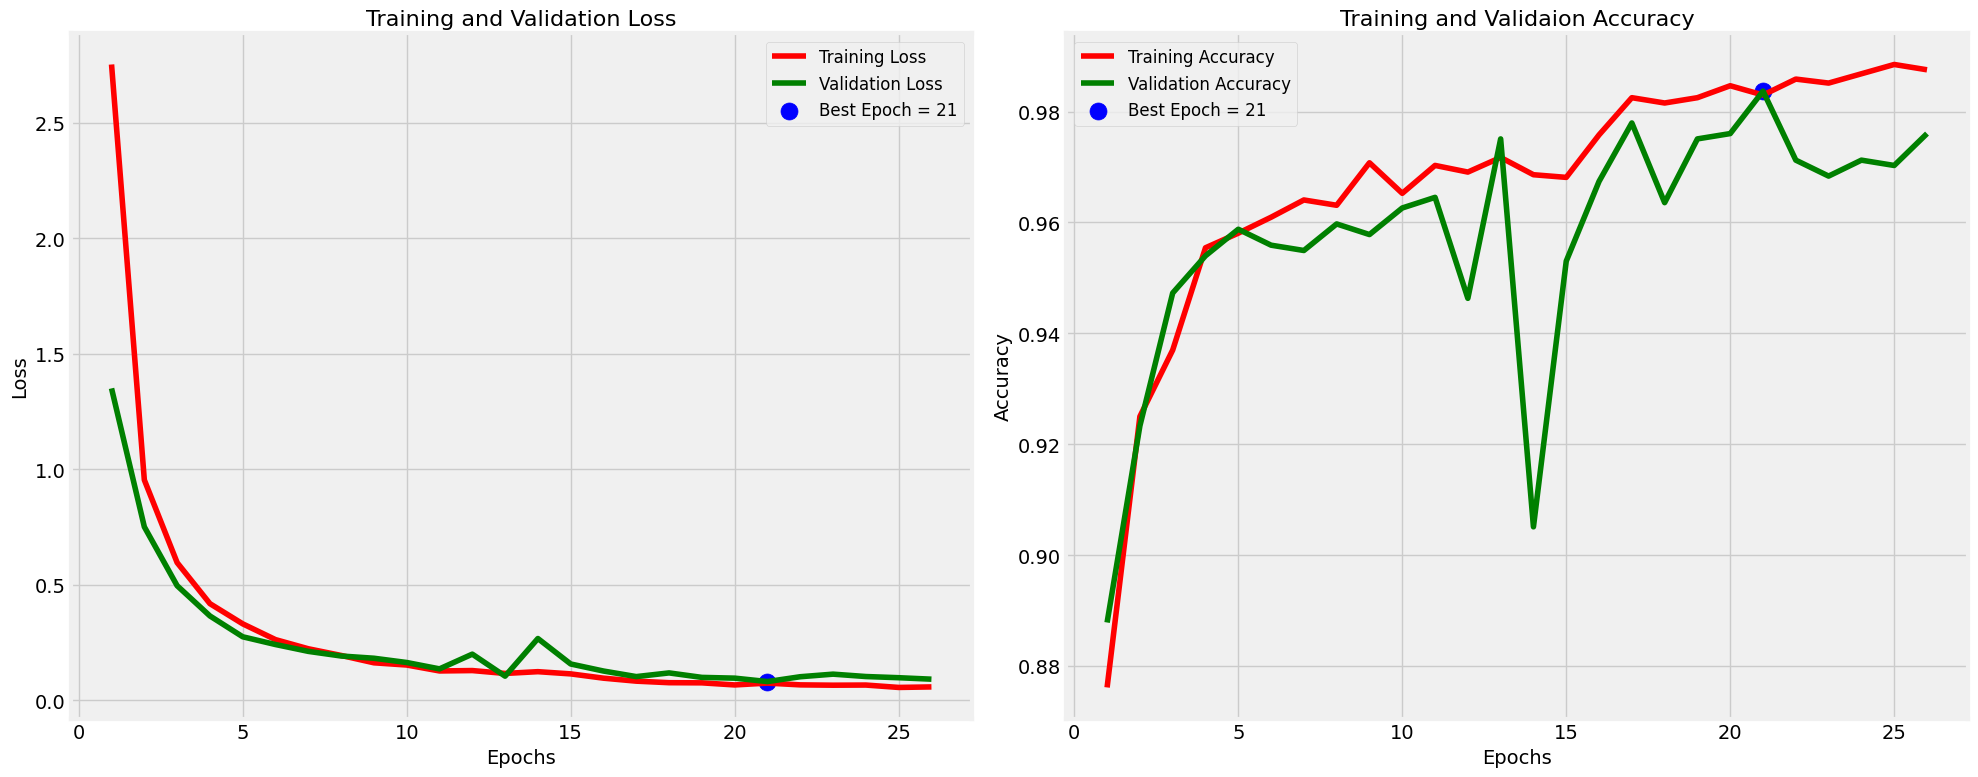

In [12]:
# Extract metrics
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find best epochs
index_loss = np.argmin(val_loss)  # Epoch with lowest validation loss
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)  # Epoch with highest validation accuracy
acc_highest = val_acc[index_acc]

# Epochs
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

# Plot Performance
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validaion Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [13]:
# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

c:\Users\Angelina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9217 - loss: 0.3113
Test Accuracy: 0.94
Test Loss: 0.25


In [14]:
# Generate Classification Report
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
              precision    recall  f1-score   support

      Normal       0.95      0.88      0.92       234
   Pneumonia       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



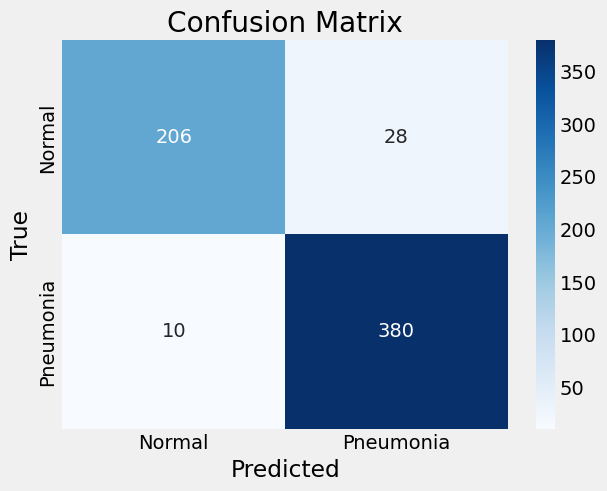

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


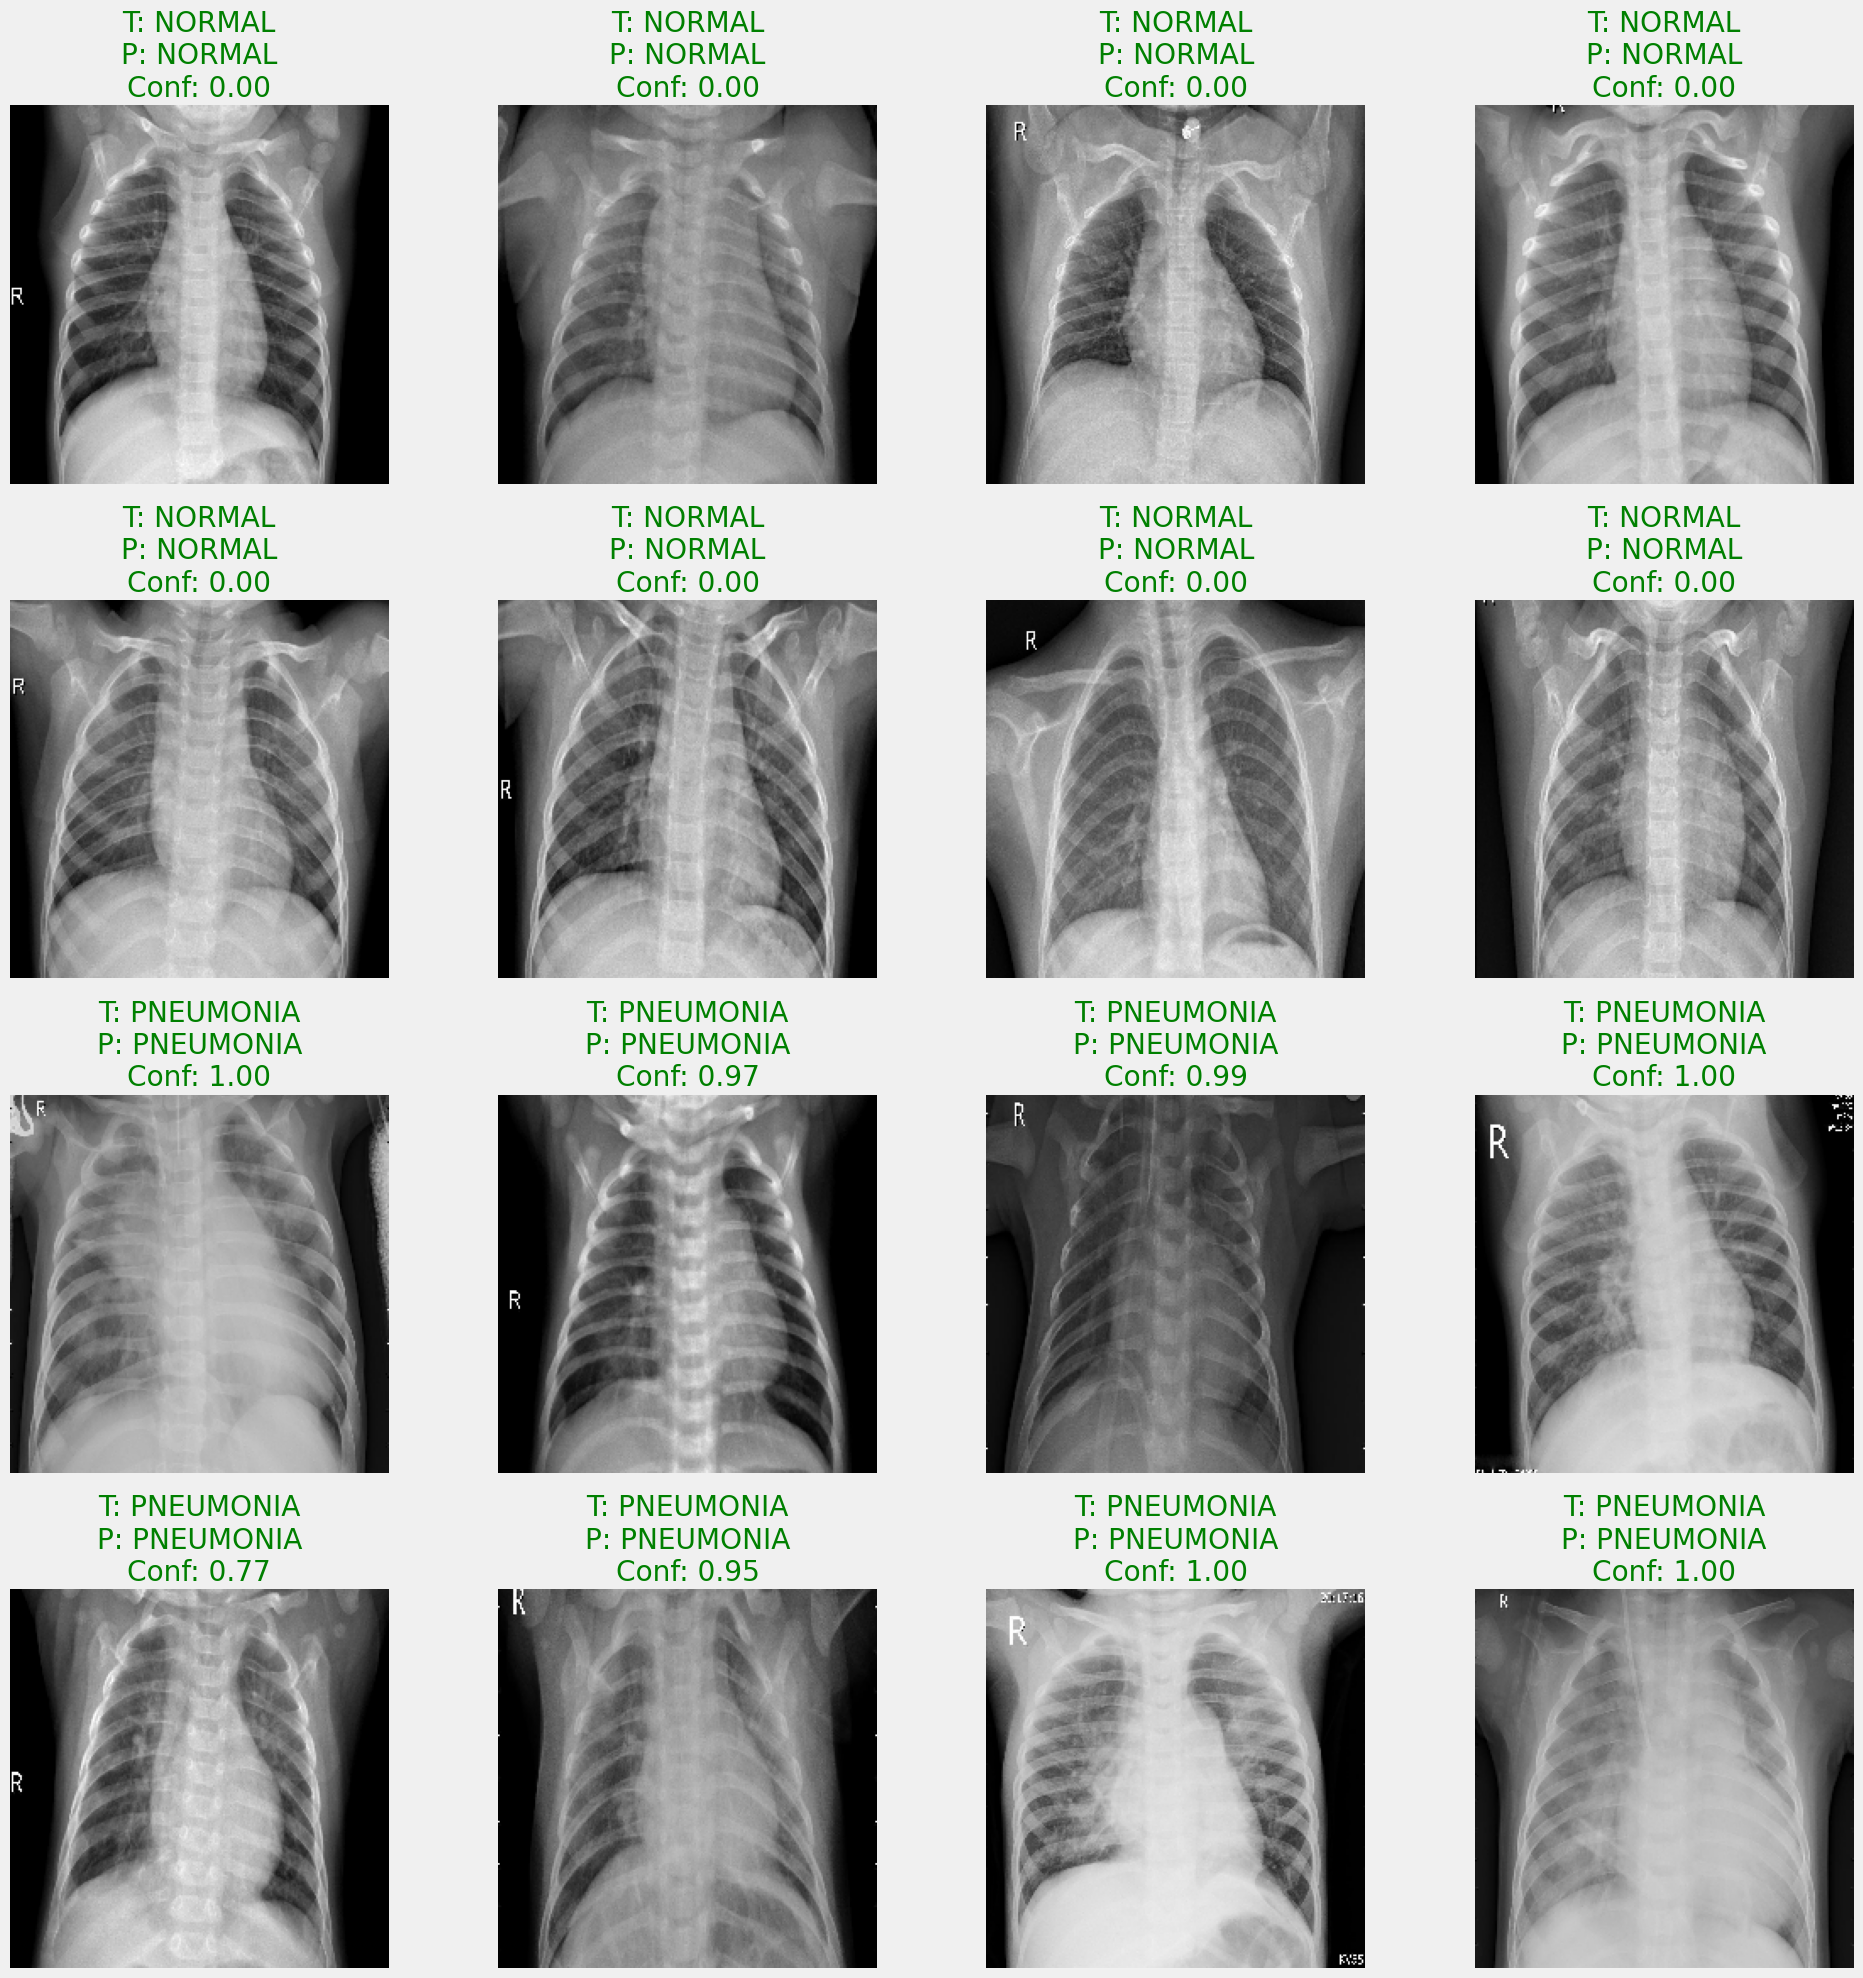

In [18]:
# Function to manually load images for each class
def load_images_for_visualization(dir_path, class_names, target_size=(224, 224), max_images_per_class=8):
    images = []
    labels = []
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dir_path, class_name)
        image_files = os.listdir(class_dir)
        random.shuffle(image_files)  # Shuffle the list to make selection random
        image_files = image_files[:max_images_per_class]  # Load a limited number of images
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=target_size)  # Resize image
            img_array = img_to_array(img) / 255.0  # Normalize image
            images.append(img_array)
            labels.append(label_idx)  # Assign 0 for 'Normal', 1 for 'Pneumonia'
    return np.array(images), np.array(labels)

# Load images from the test directory for both classes
class_names = ["NORMAL", "PNEUMONIA"]
x_test_manual, y_true_manual = load_images_for_visualization(test_dir, class_names)

# Predict using the model
y_pred_manual = model.predict(x_test_manual)
y_pred_classes_manual = (y_pred_manual > 0.5).astype("int32").flatten()

# Visualize Results
plt.figure(figsize=(20, 20))
for i in range(len(x_test_manual)):
    plt.subplot(4, 4, i + 1)  # 4x4 grid
    plt.imshow((x_test_manual[i] * 255).astype("uint8"))  # Rescale for visualization
    true_label = class_names[y_true_manual[i]]
    pred_label = class_names[y_pred_classes_manual[i]]
    
    # Get the confidence score (probability for class "PNEUMONIA")
    confidence = y_pred_manual[i][0]  # Confidence score for "PNEUMONIA" (index 0)
    
    # Display the label, prediction, and confidence
    plt.axis("off")
    plt.title(f"T: {true_label}\nP: {pred_label}\nConf: {confidence:.2f}", 
              color=("green" if true_label == pred_label else "red"))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [19]:
# Save the trained model
model.save('best_vgg16_model.keras')